# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [204]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


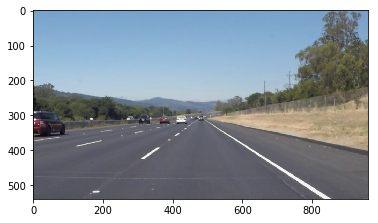

In [205]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [233]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lines = parse_slope(lines, True, .5, .9)
    right_lines = parse_slope(lines, False, .5, .9)
    
    """
    for line in range(0, len(right_lines)):
        x1,y1,x2,y2 = right_lines[line]
        x1,y1,x2,y2 = extrapolate(img, False, x1, y1, x2, y2)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    for line in range(0, len(left_lines)):
        x1,y1,x2,y2 = left_lines[line]
        x1,y1,x2,y2 = extrapolate(img, True, x1, y1, x2, y2)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """
    x1,y1,x2,y2 = average_lines(img, left_lines)
    #x1,y1,x2,y2 = extrapolate(img, False, x1, y1, x2, y2)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    x1,y1,x2,y2 = average_lines(img, right_lines)
    #x1,y1,x2,y2 = extrapolate(img, True, x1, y1, x2, y2)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

def average_lines(img, lines):
    height_usable = 350
    bottom = image.shape[0]
    total_slope = 0
    total_intercept = 0
    total_lines = 0
    for line in range(0, len(lines)):
        x1,y1,x2,y2 = lines[line]
        #y = mx + b
        if ((x2 - x1) != 0):
            slope = (y2 - y1)/(x2 - x1)
            total_intercept += y2 - slope * x2
            total_slope += slope
            total_lines += 1
    avg_slope = total_slope / total_lines
    avg_intercept = total_intercept / total_lines
    
    print(avg_slope)
    print(avg_intercept)
    
    y2 = height_usable
    x2 = int((y2 - avg_intercept)/avg_slope)
    y1 = bottom
    x1 = int((y1 - avg_intercept)/avg_slope)
    return x1,y1,x2,y2 
    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
     

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [234]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [239]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def pipeline(initial_img):
    img = grayscale(initial_img)

    cannyd = canny(img, 100, 300)
    cannyd = gaussian_blur(cannyd, 5)

    hough, lines = hough_lines(cannyd, 2, np.pi/180, 50, 20, 30)

    height = img.shape[0]
    width = img.shape[1]
    vertices = np.array([[400, 350], [width - 380, 350], [width, height], [100, height]])
    polygoned = region_of_interest(hough, [vertices])

    output = weighted_img(polygoned, initial_img, α=0.8, β=1., λ=0.)
    return output
    plt.imshow(output)
    
def get_slope(row):
    return (row[3] - row[1])/(row[2] - row[0])

def parse_slope(lines_array, positive, min_slope, max_slope):
    slopes = np.apply_along_axis(get_slope, 2, lines_array)
    
    if positive:
        slopes[slopes > max_slope] = 0
        slopes[slopes < min_slope] = 0
        lines_array = np.array(lines_array[np.where(slopes > 0)])
    else:
        slopes[slopes < -max_slope] = 0
        slopes[slopes > -min_slope] = 0
        lines_array = np.array(lines_array[np.where(slopes < 0)])

    return lines_array
    
def extrapolate(img, positive, x1, y1, x2, y2):
    #top of image
    height_usable = 350
    center = img.shape[1]/2
    #Bottom of image, right and left are different
    bottom = image.shape[0]
    bottom_left = 100
    bottom_right = image.shape[1]
    # get slope then extrapolate til we near max
    if ((x2 - x1) == 0):
        return x1,y1,x2,y2
    slope = (y2 - y1)/(x2 - x1)
    #print("Slope:" + str(slope))
    b = y2 - slope * x2
    #y = mx + b
    if positive:
        if slope > 0:
            y2 = height_usable
            x2 = int((y2 - b)/slope)
            y1 = bottom
            x1 = int((y1 - b)/slope)
    else:
        if slope < 0:
            y2 = height_usable
            x2 = int((y2 - b)/slope)
            y1 = bottom
            x1 = int((y1 - b)/slope)
    
    return x1,y1,x2,y2

initial_img = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
pipeline(initial_img)




0.57835336784
-4.93593029818
-0.629916064577
651.567957876


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [240]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [241]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return pipeline(image)

Let's try the one with the solid white lane on the right first ...

In [242]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

0.595878445297
25.1783670082
-0.627966208034
629.850069651
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|          | 2/222 [00:00<00:14, 15.27it/s]

0.595878445297
25.1783670082
-0.627966208034
629.850069651
0.641386154411
7.33430785221
-0.671319775061
640.691105074
0.604112738012
19.1794686294
-0.61590069134
620.98546706


  2%|▏         | 4/222 [00:00<00:13, 16.17it/s]

0.607520088466
71.8924618203
-0.640565721801
645.83786566


  3%|▎         | 7/222 [00:00<00:12, 17.51it/s]

0.587669013384
29.0947508131
-0.616994367129
625.365320076
0.605219441554
18.0853239391
-0.587876102508
610.780393816
0.569306487331
60.046660999
-0.623004886148
622.649510219
0.640609763341
28.4105312257
-0.613263503776
617.644575078
0.619917971517
9.85914395144
-0.615301759367
620.364721369


  6%|▌         | 13/222 [00:00<00:10, 20.41it/s]

0.679133507961
73.4686530142
-0.586953842192
609.608542776
0.669281442468
12.0764170816
-0.60126226246
626.07949586
0.602779833355
53.8477269384
-0.624585422309
642.238186216
0.628617277723
35.4385529301
-0.616463984105
615.538657523
0.626710720241
48.2807617643
-0.617684116237
618.82971593


  9%|▊         | 19/222 [00:00<00:08, 22.93it/s]

0.662992943551
8.77701508133
-0.599264386684
610.865318498
0.645085550293
5.37784206583
-0.634337532314
627.779592627
0.654949026502
61.44784444
-0.626894298469
624.747429045
0.641439537414
14.9552983769
-0.578082870384
607.322514644
0.612032536432
80.1356872296
-0.591338560042
610.218760316
0.624036022776
33.2945401124
-0.626139816673
642.536994494


 10%|▉         | 22/222 [00:00<00:08, 23.34it/s]

0.624119823762
12.3054012585
-0.589268617346
614.327479128
0.648691708948
6.80499868369
-0.575423699763
615.76911025
0.606099664765
34.2184237713
-0.614700433525
632.224672227
0.672292831016
10.0341952722
-0.595631396552
620.546057243


 11%|█▏        | 25/222 [00:01<00:08, 23.64it/s]

0.607931758957
12.7049667045
-0.586405947699
613.093352415


 13%|█▎        | 28/222 [00:01<00:08, 23.33it/s]

0.63120107796
5.0435318979
-0.618854893655
631.297935648
0.608244994922
20.1297653152
-0.669479593774
658.910485966
0.668538629563
-23.7036621333
-0.640458828934
634.166516395
0.636310506637
1.75705659662
-0.608898843708
630.962251425
0.616422527755
43.1551515458
-0.592680241234
616.898954651


 15%|█▌        | 34/222 [00:01<00:07, 23.82it/s]

0.683422687958
-37.4114072466
-0.581966045272
608.948332464
0.660086503205
-19.0366194873
-0.604277100043
617.67722133
0.63797220157
-2.57349377594
-0.61030070644
625.836771391
0.641649393566
-3.78004315642
-0.594645385712
602.692981253
0.607216327716
21.7980963909
-0.637093208514
621.158856078


 17%|█▋        | 37/222 [00:01<00:07, 23.78it/s]

0.645761394794
20.085994781
-0.641857096057
624.372476833
0.614254732773
17.502048238
-0.640211728399
642.88774643
0.630356181838
46.1074122131
-0.701140175822
648.792642948
0.671674125642
-49.7133233766
-0.645022655393
625.746511423
0.669074717516

 18%|█▊        | 40/222 [00:01<00:07, 24.20it/s]


-23.0989864204
-0.674435308696
640.989707322
0.633106201315

 19%|█▉        | 43/222 [00:01<00:07, 24.34it/s]


54.4594983633
-0.668539357076
668.236145984
0.678009561169
61.0764960361
-0.609205900856
616.350583026
0.635677040722
3.11193074264
-0.653500655455
629.611825077
0.69033043669
-41.0258797814
-0.614728592454
617.99891682
0.654511418721
5.58580400828
-0.626973437373
628.161660694


 22%|██▏       | 49/222 [00:02<00:07, 24.10it/s]

0.647540168351
40.4488571644
-0.643403161205
635.390357281
0.64193220384
35.0961710869
-0.671835706842
657.282487121
0.674505313391
-7.65711861754
-0.625045357135
613.624192823
0.670017750152
40.1705214393
-0.661008782715
644.002175048
0.66585873154
-21.9992480121
-0.68119745203
654.877863844


 23%|██▎       | 52/222 [00:02<00:07, 23.53it/s]

0.649216323722
-63.9000225546
-0.627126034671
647.911181253
0.603075929335
23.7725150461
-0.648621901895
635.338972588
0.621163680056
13.3051558002
-0.672162132972
669.266356658
0.702063929275
28.7903148479
-0.625092571873
635.784060114


 25%|██▍       | 55/222 [00:02<00:06, 23.95it/s]

0.63508044132
-19.6877800414
-0.623772150419
619.747752635


 26%|██▌       | 58/222 [00:02<00:06, 23.52it/s]

0.64581351492
-4.85770793543
-0.613589535848
615.080116959
0.643047258526
10.1080349456
-0.625943793284
643.571000796
0.661339660101
51.1325902854
-0.606071702505
609.238215952
0.647331479143
37.3869658317
-0.66292676394
668.123515263
0.656292417573
-18.3258491937
-0.594563059546
609.419178906


 29%|██▉       | 64/222 [00:02<00:06, 23.22it/s]

0.667685405352
2.76476484797
-0.677184065467
648.591010095
0.645255105987
-1.09204438992
-0.600217198055
615.997150808
0.701347994229
-36.0040473208
-0.634400095306
663.27443522
0.635159612803
59.7808357081
-0.613626072534
636.455626825
0.694595545911
41.3308760357
-0.625525577643
636.778149591


 30%|███       | 67/222 [00:02<00:06, 23.14it/s]

0.667759600887
35.621838274
-0.626817022327
659.213234424
0.64669798141
-73.7230852026
-0.620012099755
651.943574331
0.647680981915
-22.4513711565
-0.583588583056
631.000282559
0.659357212579
13.8466365556
-0.581394604863
623.223612952


 32%|███▏      | 70/222 [00:03<00:06, 23.19it/s]

0.691887703432
-16.9224970556
-0.635252182013
662.51283441


 33%|███▎      | 73/222 [00:03<00:06, 22.80it/s]

0.640998983944
-28.0469481014
-0.630337684894
640.174431264
0.68119624132
-3.69926007723
-0.646003486273
647.688082745
0.637890312221
-24.4101437474
-0.65034461476
670.372778128
0.691672936861
-41.0437068793
-0.613257665068
638.088072708
0.630430929557
-20.4516203453
-0.618066507943
640.198707121


 36%|███▌      | 79/222 [00:03<00:06, 22.30it/s]

0.632728447533
33.4992451093
-0.629261419375
635.723881054
0.664175927611
23.0692928513
-0.607413310365
622.205966103
0.664920312627
-45.9174812444
-0.613326529801
665.948464603
0.640122303137
9.18653259142
-0.62391093168
676.08521267
0.671337894857
-100.132795478
-0.612164480991
636.849469353


 37%|███▋      | 82/222 [00:03<00:06, 22.02it/s]

0.625069546963
20.6895077428
-0.62024459731
623.587039764
0.658572221057
-74.6380166463
-0.611091765166
613.435091859
0.66938031378
-53.7212224783
-0.577491856229
595.200555123
0.658087920941
-54.7613663043
-0.640297180781
642.599821066


 38%|███▊      | 85/222 [00:03<00:06, 21.89it/s]

0.652785273075
-19.0502065471
-0.638345449971
637.797102069


 40%|███▉      | 88/222 [00:03<00:06, 21.45it/s]

0.659845160908
-53.5351757213
-0.642236364733
635.878392548
0.654414664558
-11.7437417068
-0.657032869345
622.525658776
0.686868004874
-25.2997556199
-0.620224956499
601.846316405
0.676027699827
8.89202777363
-0.623524800696
638.815167109
0.649769500416

 41%|████      | 91/222 [00:04<00:06, 20.84it/s]


-17.5129503004
-0.602457657107
609.996037489
0.644850568943
39.2915058906
-0.652957802401
632.429342501
0.708358209563
64.3195375355
-0.623406810354
622.644238625
0.716157509535
-11.8709402935
-0.665335687058
635.616693115


 42%|████▏     | 94/222 [00:04<00:06, 21.04it/s]

0.70191269635
14.3960371958
-0.66358267889
631.272395726


 44%|████▎     | 97/222 [00:04<00:05, 20.99it/s]

0.688792566663
-26.9686882315
-0.637756347554
612.607120514
0.66321878371
-9.00962998301
-0.618929003447
620.148888707
0.704117902879
-19.8923197699
-0.587484427278
607.596147946
0.677985999498
-19.1475184857
-0.661466852192
624.148818755
0.723057216155
-26.5082785357
-0.663537527625
624.757924202


 45%|████▌     | 100/222 [00:04<00:05, 20.70it/s]

0.700282827808
-11.7323978543
-0.647380586536
617.966082261
0.669854029553
47.9830967858
-0.64349458544
619.168399449
0.705765452688
-97.1179281032
-0.679510439528
632.23132285
0.67156903751
63.7661156681
-0.626219237605
619.34743638


 46%|████▋     | 103/222 [00:04<00:05, 20.54it/s]

0.680907989108
-22.6624103118
-0.581683511953
595.269579672


 48%|████▊     | 106/222 [00:04<00:05, 20.78it/s]

0.712874794455
-48.0504255046
-0.642819288545
629.038529042
0.681628476888
-24.9157485493
-0.661793261267
626.630270554
0.672358797497
-3.2463576101
-0.67517813832
617.847651026
0.688788376976
-29.8686396483
-0.593737991397
622.466859986


 49%|████▉     | 109/222 [00:04<00:05, 20.77it/s]

0.669011921706
-16.7573955718
-0.664701894556
637.677048549


 50%|█████     | 112/222 [00:05<00:05, 20.39it/s]

0.672395291441
-17.8877097615
-0.680832916059
635.400900366
0.674116354391
11.8299989924
-0.639049849633
624.818934935
0.712293516771
-48.3557917571
-0.678777400478
635.324552054
0.6743388606
-13.0777551848
-0.678714935563
568.129640001


 52%|█████▏    | 115/222 [00:05<00:05, 20.21it/s]

0.627233696178
12.7978011075
-0.689074678885
617.755773204
0.690236607125
-36.138650392
-0.652108938446
630.500268224
0.698092089679
-42.7823865447
-0.64501987687
599.392898688
0.640274725653
-15.0287698357
-0.655049190886
651.407159304
0.654924819016
-45.7520723273
-0.645235317846
658.226161416


 55%|█████▍    | 121/222 [00:05<00:05, 19.86it/s]

0.641354024507
-14.0917324005
-0.596801631954
630.039528372
0.672135911325
-82.1959334608
-0.675322498588
648.106188773
0.63176350192
6.01496898502
-0.577947527914
614.507472445
0.622694530506
-5.21694561449
-0.659110674926
658.011341117


 56%|█████▋    | 125/222 [00:05<00:05, 19.21it/s]

0.650144536638
10.495810208
-0.649387275431
645.969307905
0.632780702798
-58.7985862462
-0.670137194911
648.868898585
0.619017060561
-2.6408880772
-0.679449582025
634.477396502
0.614634291664
15.1407405919
-0.681134716588
691.310114718


 58%|█████▊    | 129/222 [00:05<00:04, 19.32it/s]

0.680481007484
9.04921329782
-0.644796832485
577.925186437
0.594874540531
-51.9285722421
-0.589546668291
608.409312949
0.632859078338
-112.408630412
-0.660306021938
657.200759198
0.627007669768
17.9194795232
-0.619010634988
615.109832564


 60%|█████▉    | 133/222 [00:06<00:04, 18.61it/s]

0.601004759426
25.3598617749
-0.678183636538
674.465068898
0.624261313254
6.8642329885
-0.683681300767
665.264748626
0.638990046191
-23.5109991879
-0.673283930638
657.530562067
0.650824902183
-29.6326759607
-0.71414594127
655.005529102


 62%|██████▏   | 137/222 [00:06<00:04, 18.63it/s]

0.656915379737
-28.8536508877
-0.695415433729
642.339647504
0.61167247709
-4.83963182507
-0.674399917761
624.855597223
0.635631169862
-54.3659201976
-0.704646042654
631.41659089
0.61852591692
-29.3758927363
-0.64452589814
620.55452275


 64%|██████▎   | 141/222 [00:06<00:04, 19.08it/s]

0.631516705302
-8.6285788631
-0.590237843538
610.297015395
0.617548234236
11.3591125826
-0.65152067591
623.769905795
0.620145664729
10.258673439
-0.646400230366
644.124128316
0.630409596298
-7.23704008891
-0.664747871674
633.959490968


 64%|██████▍   | 143/222 [00:06<00:04, 18.96it/s]

0.598367939858
26.1908954177
-0.664451560883
652.300164824
0.62894243411
4.19067143655
-0.66361401953
646.71158322
0.657860974683
-11.0672259368
-0.67184608691
680.669346203
0.62789883513
0.852713087044
-0.682535719895
661.204484303


 66%|██████▌   | 146/222 [00:06<00:03, 19.47it/s]

0.652992058688

 68%|██████▊   | 151/222 [00:07<00:03, 19.97it/s]


-17.731997158
-0.684102697064
640.749485461
0.647836947896
-17.8331560539
-0.710886134025
671.04104351
0.596823493775
13.5900813842
-0.637310113606
631.854059447
0.604796923669
16.2146383066
-0.630625840094
626.123479046
0.598443964204
8.68699978878
-0.659835983968
626.954391517


 69%|██████▉   | 154/222 [00:07<00:03, 19.63it/s]

0.60318113397
32.980923134
-0.679494908527
676.161739805
0.636719389527
54.662928204
-0.701628325323
684.683181653
0.579477784361
35.1152613764
-0.655537634608
644.082635954
0.63543834404
-20.5643155023
-0.684447539819
646.252576855


 71%|███████   | 158/222 [00:07<00:03, 18.97it/s]

0.681314830232
-129.995033938
-0.713928127264
648.790782311
0.63412489277
-34.2732510016
-0.697679774738
656.939551509
0.622995502793
-0.278528235297
-0.68569128278
670.834838812
0.583065608346
15.1573222251
-0.688285795676
651.806802439


 73%|███████▎  | 162/222 [00:07<00:03, 18.97it/s]

0.611795432648
-7.95689377018
-0.667325333362
660.23431908
0.612685824759
-21.9876321257
-0.658518914413
647.961971139
0.600726922131
58.6806205906
-0.602285422183
637.005247266
0.625371452821
-48.1218818019
-0.605743152822
636.975706532


 75%|███████▍  | 166/222 [00:07<00:02, 18.74it/s]

0.606874448746
7.73824464552
-0.614519300843
659.287688913
0.617878919456
-85.5495761872
-0.61601596783
638.762364568
0.573915991095
-37.4015773236
-0.634148805447
648.903353152
0.575233377667
-45.4709659033
-0.637684765193
647.401115204


 77%|███████▋  | 170/222 [00:08<00:02, 18.56it/s]

0.569231285774
-29.0344988736
-0.595017141978
644.257379144
0.596149454506
18.5190415438
-0.660361253378
651.144490869
0.622441313303
-4.40840594222
-0.644027952978
653.509961975
0.579983579383
15.1192449389
-0.756714583915
671.91458893


 79%|███████▉  | 175/222 [00:08<00:02, 19.14it/s]

0.592910966195
-50.4598329892
-0.682716850514
642.252807055
0.617197800062
-86.5431533268
-0.70254017559
658.739259222
0.591601905128
-34.3977393735
-0.592111160443
622.493184684
0.590996850034
-0.106655983091
-0.633535281514
639.475553825
0.593047099386

 81%|████████  | 179/222 [00:08<00:02, 19.24it/s]


19.8215891625
-0.611672030563
622.130519054
0.624780275107
-20.0567952686
-0.634979864774
637.920398423
0.586503973606
25.4647557519
-0.614005237084
632.418828939
0.574211927895
35.4578687912
-0.626591094338
643.523237763


 82%|████████▏ | 183/222 [00:08<00:02, 19.03it/s]

0.641246386457
-74.4792101782
-0.74252368134
672.581982235
0.582580914985
6.22443769436
-0.658100810343
649.172779023
0.592222028592
17.9616572683
-0.74453499868
674.47037413
0.58223744161
25.4168589829
-0.658871082455
651.956596526


 84%|████████▍ | 187/222 [00:08<00:01, 19.04it/s]

0.597419697893
5.62272549467
-0.682262498238
644.627183488
0.576986378687
36.7443596713
-0.699231661804
678.615372399
0.590610787485
11.0001652484
-0.62153448991
634.122426719
0.565490542114
52.7927938428
-0.620861331338
639.405785645


 86%|████████▌ | 191/222 [00:09<00:01, 18.63it/s]

0.591788462806
-39.7003872297
-0.638833521867
633.298942275
0.577420240879
10.3454617892
-0.583086619001
620.454893487
0.57881970125
-4.79144704905
-0.622642321663
643.165820821
0.550811168671
43.0214146812
-0.600436499442
625.874144213


 88%|████████▊ | 195/222 [00:09<00:01, 18.19it/s]

0.544438820485
26.294085683
-0.674737817659
662.125055025
0.558540774113
12.6962157036
-0.701771583224
671.767870485
0.582487869051
13.1844401248
-0.694498605062
657.425656217
0.576581901837
19.2454373182
-0.631406090793
659.951502857


 90%|████████▉ | 199/222 [00:09<00:01, 18.64it/s]

0.571652617025
10.8106807247
-0.676222365563
678.37495746
0.597567235992
39.2695617493
-0.674591097457
635.575659517
0.581676127986
-21.5471552681
-0.706303341982
658.922503071
0.556105314211
45.9354101652
-0.66784817376
640.161535364


 91%|█████████ | 201/222 [00:09<00:01, 18.92it/s]

0.581208072741
-3.49542133884
-0.643541785181
646.499535345
0.551405425848
42.5443554401
-0.609342835932
634.285841824
0.618934104156
-102.991441172
-0.641845197715
650.393960511
0.584339806715
7.63733606487
-0.689660559989
650.641056623
0.599052857264
-55.5936333258
-0.727928527885
661.835306955


 93%|█████████▎| 207/222 [00:09<00:00, 19.64it/s]

0.610473115357
-30.2465186793
-0.698540104517
663.971441321
0.561681664367
12.3857374079
-0.728922684401
660.802016587
0.576039830046
3.86885719378
-0.773544794116
681.270162719
0.5669246006
1.85283830153
-0.785214670095
682.073644412


 95%|█████████▌| 211/222 [00:10<00:00, 19.42it/s]

0.552849471285
15.34633099
-0.737328217696
670.404707885
0.557208080549
4.91043752185
-0.731060099842
651.471123734
0.582058476468
-43.4756731929
-0.710371782107
655.739104716
0.600978206471
-26.9687095648
-0.69471517117
660.638539175


 97%|█████████▋| 215/222 [00:10<00:00, 16.12it/s]

0.571835401918
20.2466288421
-0.704756320931
620.905914328
0.561877164071
38.9233146507
-0.724691289564
672.759129812
0.559234356068
23.8011445202
-0.696074592222
659.326632563


 99%|█████████▊| 219/222 [00:10<00:00, 15.85it/s]

0.552841963189
28.8044338348
-0.750558076609
678.9574954
0.582835762098
31.1166411065
-0.788075253473
686.351410294
0.554033343744
37.5997492633
-0.778728413124
679.632497723
0.594509456048
23.0313174573
-0.819432126666
694.050855306


100%|█████████▉| 221/222 [00:10<00:00, 16.64it/s]


0.55653501193
43.8985043445
-0.798353552826
666.927758808
0.564126713921
38.0174115231
-0.736694452107
667.98868588
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 10.5 s, sys: 1.17 s, total: 11.7 s
Wall time: 11.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [243]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [244]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

0.669214886698
-51.919864007
-0.599755367783
612.682882755
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 2/682 [00:00<00:42, 16.13it/s]

0.669214886698
-51.919864007
-0.599755367783
612.682882755
0.633912378636
0.469507348855
-0.601893742913
606.987859969
0.656080406402
-26.8979703107
-0.611506010765
617.204292851


  1%|          | 4/682 [00:00<00:40, 16.69it/s]

0.634158201991
-8.73035583842
-0.622635805468
626.944426429


  1%|          | 6/682 [00:00<00:39, 17.16it/s]

0.626557666334
-0.45816512086
-0.613191281409
666.20854965
0.633451187429
-19.2043474984
-0.637825508761
673.600719105
0.670841140884
-20.716747931
-0.664447131322
662.902478581


  1%|          | 8/682 [00:00<00:38, 17.36it/s]

0.641747040545
-42.2370128471
-0.621329543056
632.702649584


  1%|▏         | 10/682 [00:00<00:39, 17.21it/s]

0.642016001412
-18.2428532737
-0.65502665786
633.439197925
0.643778487933
-31.6179218013
-0.618487474759
659.209444263
0.63543172099
-25.5227191647
-0.631403508955
628.186814996


  2%|▏         | 12/682 [00:00<00:38, 17.43it/s]

0.623436948904
6.77321228006
-0.64281038244
628.060111187


  2%|▏         | 14/682 [00:00<00:38, 17.42it/s]

0.614184987805
-36.6661666054
-0.639975779071
666.750424284
0.638527276098
-6.46845810117
-0.628791044494
629.102269439
0.624167307686
2.41944035475
-0.657574393099
663.873854967


  2%|▏         | 16/682 [00:00<00:38, 17.34it/s]

0.650526361548
-21.3532120358
-0.646075610023
705.154241974


  3%|▎         | 18/682 [00:01<00:38, 17.46it/s]

0.657498278542
-55.588041806
-0.674787537976
646.064008669
0.630239854573
2.77456069356
-0.644147780958
650.851355867
0.620503448961
6.9957241426
-0.650570822078
651.672512647


  3%|▎         | 20/682 [00:01<00:37, 17.45it/s]

0.627281764644
-26.0401964805
-0.680598611989
630.111805793


  3%|▎         | 22/682 [00:01<00:37, 17.42it/s]

0.628814804515
6.94944393478
-0.694203419563
701.511764908
0.692318662912
82.9502478706
-0.698157266007
622.918237267
0.628178025932
-17.7426376404
-0.720467848845
636.455396501


  4%|▎         | 24/682 [00:01<00:38, 17.18it/s]

0.639010144291
-5.70244238403
-0.712409468914
609.427083885


  4%|▍         | 26/682 [00:01<00:38, 16.98it/s]

0.619202311384
-11.8997115123
-0.717830778295
654.933734512
0.614335140012
-2.81461823472
-0.705960507596
691.378757457
0.602367451353
22.0377029718
-0.751927046612
629.221092204


  4%|▍         | 28/682 [00:01<00:39, 16.62it/s]

0.625734374103
-31.1753136892
-0.715967597283
683.106154602


  4%|▍         | 30/682 [00:01<00:38, 16.92it/s]

0.612289295059
-8.02782412057
-0.682497268156
697.312233701
0.608683385876
6.44155913091
-0.670283598838
635.487657065
0.604845049779
11.5705542778
-0.764667761683
691.805778247


  5%|▍         | 32/682 [00:01<00:37, 17.14it/s]

0.596314378639
18.5007341278
-0.696378924863
612.023905191


  5%|▍         | 34/682 [00:01<00:37, 17.22it/s]

0.630146797325
-43.7107009971
-0.7431627395
619.991334746
0.626096131971
-40.4189972858
-0.732484085055
606.58546372
0.625536946825
-30.8815770987
-0.744379764322
621.238903777


  5%|▌         | 36/682 [00:02<00:37, 17.15it/s]

0.651037180138
-86.2874228397
-0.691619340355
624.185387954


  6%|▌         | 38/682 [00:02<00:37, 17.17it/s]

0.600298168034
35.7117159391
-0.734434005664
594.37451592
0.619504620228
1.79435450479
-0.719861914513
610.514986401
0.606820374266
12.1236249092
-0.70820048437
604.058162769


  6%|▌         | 40/682 [00:02<00:37, 17.16it/s]

0.600456538238
6.4728153907
-0.700179869116
609.629179434


  6%|▌         | 42/682 [00:02<00:37, 16.98it/s]

0.605627736117
35.3455644669
-0.739041760897
631.898112688
0.587255231492
21.1604261837
-0.78619955372
664.437321627
0.588647945141
11.7896300438
-0.705017870856
572.473545645


  6%|▋         | 44/682 [00:02<00:37, 16.88it/s]

0.611027111594
6.73129696454
-0.694497109521
603.850334735


  7%|▋         | 46/682 [00:02<00:37, 16.84it/s]

0.576809199095
31.7207007568
-0.700345806802
614.432580152
0.608625404441
34.1826840139
-0.715459225097
550.659921231
0.610414895125
9.18437042621
-0.697765936717
615.443384136


  7%|▋         | 48/682 [00:02<00:37, 16.94it/s]

0.605389192698
1.03615037495
-0.773591401518
661.816192101


  7%|▋         | 50/682 [00:02<00:37, 16.78it/s]

0.594236681878
17.3371106504
-0.733602741386
628.273764679
0.628233922339
-19.5106877591
-0.690232788318
613.542628649
0.627212724638
-27.4304809873
-0.730840297231
628.158738039


  8%|▊         | 52/682 [00:03<00:38, 16.57it/s]

0.596202188771
12.5277897979
-0.675344365653
653.03972966


  8%|▊         | 54/682 [00:03<00:38, 16.35it/s]

0.615096469832
8.30670312659
-0.714801022836
663.551667894
0.587318686145
27.6760398937
-0.704599007133
645.496286168
0.58970850143
31.2054704915
-0.695352224029
653.256619104


  8%|▊         | 56/682 [00:03<00:37, 16.51it/s]

0.578690443575
24.6883357602
-0.692430090813
655.688504


  9%|▊         | 58/682 [00:03<00:37, 16.65it/s]

0.620448827028
60.869738769
-0.726922392787
658.85813255
0.593266716978
14.9910668633
-0.714169157063
671.618973002
0.631021753859
-87.507939523
-0.682885913072
646.362362521


  9%|▉         | 60/682 [00:03<00:37, 16.69it/s]

0.617592632803
-29.004934052
-0.719791134139
639.516011752


  9%|▉         | 62/682 [00:03<00:36, 16.80it/s]

0.627322094536
31.0971332937
-0.681582926539
649.811129577
0.608993627319
13.3910039058
-0.687776985431
641.356748871
0.584464783308
30.8606863537
-0.633133001664
624.171269864


  9%|▉         | 64/682 [00:03<00:36, 16.92it/s]

0.594954104193
33.8943669194
-0.691910243109
645.372840051


 10%|▉         | 66/682 [00:03<00:36, 16.87it/s]

0.616501191462
-13.2126089456
-0.691708334846
643.987652169
0.595060532833
25.8860575523
-0.685150793422
673.577242214
0.592127008953
45.9565500012
-0.67876034946
706.020101217


 10%|▉         | 68/682 [00:03<00:36, 17.03it/s]

0.634522130883
25.3837805473
-0.754798639171
771.868584655


 10%|█         | 70/682 [00:04<00:35, 17.11it/s]

0.617545801205
-117.895047408
-0.717174271161
682.258227732
0.602286913425
21.0324041951
-0.686135806103
646.344385153
0.640914574028
-68.9179581942
-0.712330245832
661.192510204


 11%|█         | 72/682 [00:04<00:35, 17.14it/s]

0.664744253916
-118.74783724
-0.738333920758
649.103546058


 11%|█         | 74/682 [00:04<00:35, 17.20it/s]

0.60850924961
15.0458278173
-0.666399683807
600.857189443
0.577594580648
-28.2767846912
-0.721082455523
704.832754926
0.607839422371
-34.4717535713
-0.667501384715
634.882200577


 11%|█         | 76/682 [00:04<00:34, 17.81it/s]

0.588011299442
35.6003008035
-0.737039716408
668.326058311


 11%|█▏        | 78/682 [00:04<00:33, 18.09it/s]

0.607413826328
21.1186121816
-0.723913150516
625.856914427
0.580992275011
40.3237155003
-0.680031665226
658.926712723
0.601489934722
30.3197117693
-0.738711843523
654.558366757


 12%|█▏        | 80/682 [00:04<00:32, 18.25it/s]

0.597945639491
31.4691409247
-0.635915048367
614.665356982


 12%|█▏        | 82/682 [00:04<00:32, 18.19it/s]

0.622740496076
9.58994960283
-0.663941013189
617.150727685
0.599110896676
-4.4941005117
-0.716708619242
645.078666968
0.614344815254
28.9443887543
-0.676051309837
637.728832737


 12%|█▏        | 84/682 [00:04<00:32, 18.41it/s]

0.57305051548
37.0984077539
-0.739960565271
674.846717348


 13%|█▎        | 86/682 [00:04<00:32, 18.25it/s]

0.627987000966
18.2635695451
-0.680826218735
659.813442103
0.588008638699
31.3909637141
-0.679773293984
649.816855932
0.624064006739
7.85182882774
-0.676528547217
627.835283448


 13%|█▎        | 88/682 [00:05<00:32, 18.55it/s]

0.625171657055
18.3567032352
-0.728505937786
664.080152661


 13%|█▎        | 90/682 [00:05<00:32, 18.37it/s]

0.62295734524
39.6116852806
-0.653531177358
662.85305728
0.65288521375
40.0009569934
-0.691824673327
628.898655048
0.660520290697
24.4463391763
-0.649344349941
629.31931405


 13%|█▎        | 92/682 [00:05<00:31, 18.48it/s]

0.621441031412
21.8808438203
-0.666482898218
656.193822888


 14%|█▍        | 94/682 [00:05<00:31, 18.69it/s]

0.595592071199
34.0884209203
-0.746155760224
663.592564802
0.647371879013
33.7910200213
-0.712860228355
663.595018825
0.641345817382
-7.99672454213
-0.637378420688
626.592934525


 14%|█▍        | 96/682 [00:05<00:31, 18.67it/s]

0.679550328321
-45.9438086004
-0.692940264047
662.740124108


 14%|█▍        | 98/682 [00:05<00:31, 18.62it/s]

0.617978676047
7.9926337519
-0.68086846126
644.281609809
0.627691767254
12.4022697746
-0.630311191166
611.998814767
0.59031392194
26.9916980845
-0.670254347451
626.985399626


 15%|█▍        | 100/682 [00:05<00:31, 18.63it/s]

0.636960408158
2.25476634386
-0.71066546908
643.990616853


 15%|█▍        | 102/682 [00:05<00:31, 18.56it/s]

0.625848824185
9.8868865085
-0.658961286278
637.814799456
0.631064540822
6.2227172004
-0.680997221715
610.454731568
0.62966275228
17.7150599533
-0.700058736217
666.891936311


 15%|█▌        | 104/682 [00:05<00:31, 18.27it/s]

0.633072137222
3.84336970796
-0.693031878625
649.105679867


 16%|█▌        | 106/682 [00:06<00:31, 18.08it/s]

0.639835317532
-3.23752994884
-0.655566968016
670.677002207
0.625440779841
10.638569505
-0.646407561292
664.173941385
0.632613684095
5.06342665483
-0.725542725506
657.690056213


 16%|█▌        | 108/682 [00:06<00:31, 18.49it/s]

0.641615733387
-28.6415014202
-0.641850630281
628.442524761


 16%|█▌        | 110/682 [00:06<00:30, 18.46it/s]

0.657213718787
-14.6752575257
-0.6346506289
638.334279692
0.619412838637
13.9704378501
-0.635184325544
631.734118441
0.657497090145
-74.0871413972
-0.680106864374
634.07499136


 16%|█▋        | 112/682 [00:06<00:31, 18.31it/s]

0.620492048948
-6.96285117081
-0.662358109544
644.743995319


 17%|█▋        | 114/682 [00:06<00:30, 18.36it/s]

0.60752108156
19.2353416047
-0.663173453363
626.530308563
0.62508197875
-5.19348546732
-0.647064124986
632.136115125
0.645107982173
-18.1951982687
-0.715048132026
659.81094497


 17%|█▋        | 116/682 [00:06<00:30, 18.48it/s]

0.624547171785
8.57097537823
-0.716987033671
634.548555809


 17%|█▋        | 118/682 [00:06<00:30, 18.24it/s]

0.635542217032
-5.33203901173
-0.616997331124
628.332160938
0.631922072181
4.32324603289
-0.618131770018
644.260958616
0.618298122893
13.3586236938
-0.645548116316
623.960389224


 18%|█▊        | 120/682 [00:06<00:30, 18.27it/s]

0.634606662362
1.19027946177
-0.651991227174
653.265813452


 18%|█▊        | 122/682 [00:06<00:30, 18.23it/s]

0.617436972748
-57.1333691896
-0.64652953204
634.488449912
0.685147500069
-89.9054968229
-0.651608423181
661.022481275
0.660533864885
-105.411977931
-0.67898677661
649.58806986


 18%|█▊        | 124/682 [00:07<00:30, 18.29it/s]

0.617488144524
-50.2936593875
-0.684873790395
633.121463385


 18%|█▊        | 126/682 [00:07<00:30, 18.38it/s]

0.602422319653
11.5236285062
-0.703780682365
651.967284978
0.59585119119
12.4607966623
-0.640852257131
638.513605147
0.633907809808
-17.0001971647
-0.657525126717
642.690475024


 19%|█▉        | 128/682 [00:07<00:30, 18.03it/s]

0.631869888668
-41.4551466245
-0.71480567025
631.171881838


 19%|█▉        | 130/682 [00:07<00:30, 17.88it/s]

0.631021421811
-14.8807902101
-0.736941909633
654.983836321
0.606449524194
-7.26936507032
-0.625792047008
656.277409358
0.631450124153
-12.9456192182
-0.691241381134
687.741469177


 19%|█▉        | 132/682 [00:07<00:30, 18.02it/s]

0.727497458547
-233.712834147
-0.646129187866
649.519549702


 20%|█▉        | 134/682 [00:07<00:30, 18.09it/s]

0.707983163251
-170.000793242
-0.620294538894
639.127681993
0.599092310164
26.4344024328
-0.665233929898
656.46532678
0.579042390982
24.0364097854
-0.630025467559
641.570120005


 20%|█▉        | 136/682 [00:07<00:29, 18.44it/s]

0.614433968436
-57.1584477435
-0.647884027046
663.374838393


 20%|██        | 138/682 [00:07<00:29, 18.75it/s]

0.613954801722
-10.1151940198
-0.64997568027
684.121462945
0.61393483971
38.1468356444
-0.652230052469
664.262348456
0.596325269869
-40.6073596256
-0.639721297633
589.395138742


 21%|██        | 140/682 [00:07<00:29, 18.60it/s]

0.607070633282
2.66046117662
-0.692397995596
645.273003504


 21%|██        | 142/682 [00:08<00:28, 18.72it/s]

0.624815476593
-44.2783840185
-0.619375176909
620.851225132
0.638867242149
-49.1692200373
-0.678112664333
646.48687296
0.618434682382
-58.501971462
-0.622300642315
631.578659524


 21%|██        | 144/682 [00:08<00:28, 18.74it/s]

0.628523277505
-10.2919157288
-0.70325699717
650.304160354


 21%|██▏       | 146/682 [00:08<00:28, 18.60it/s]

0.62098541759
-52.0254504714
-0.69726225393
666.097875508
0.632308596517
6.81919834447
-0.678162627486
642.399834782
0.635209337935
6.59021071138
-0.642514935153
650.554172621


 22%|██▏       | 148/682 [00:08<00:28, 18.79it/s]

0.647811906373
-53.2629617944
-0.69469518157
648.002436945


 22%|██▏       | 150/682 [00:08<00:28, 18.84it/s]

0.664995363001
16.2856053742
-0.645682844302
646.053935676
0.643323710063
-7.47809935052
-0.741420425262
630.502851834
0.606625416109
25.8345195799
-0.670718490743
642.668965031


 22%|██▏       | 152/682 [00:08<00:27, 18.97it/s]

0.631382258503
-17.5110055923
-0.673816289983
678.96492364


 23%|██▎       | 154/682 [00:08<00:27, 18.94it/s]

0.606351678723
3.68811147317
-0.666417295658
649.852013386
0.626998647059
0.94293151332
-0.630545096135
636.499747082
0.61510673476
9.3675183489
-0.634199205584
634.271301155


 23%|██▎       | 156/682 [00:08<00:27, 19.03it/s]

0.595213862907
1.03117884565
-0.625538445204
634.918777262


 23%|██▎       | 158/682 [00:08<00:27, 19.05it/s]

0.597844074013
4.72319854529
-0.621652546304
643.353704937
0.592745008169
-12.5785806702
-0.68908276514
678.544320017
0.570530808837
28.1704724168
-0.667795728569
681.369654757


 23%|██▎       | 160/682 [00:08<00:27, 18.95it/s]

0.60971939586
7.06561626382
-0.710348076909
679.414412703


 24%|██▍       | 162/682 [00:09<00:27, 18.98it/s]

0.641895806389
-34.6853921324
-0.647734637553
640.817850189
0.586396042519
31.5525718369
-0.661503824243
630.827401938
0.604908075219
22.1824066158
-0.722811761501
660.37326815


 24%|██▍       | 164/682 [00:09<00:27, 18.93it/s]

0.615536223687
9.17724934804
-0.694420211047
652.215156898


 24%|██▍       | 166/682 [00:09<00:28, 18.42it/s]

0.56866089031
3.53665326167
-0.669920786207
664.167702679
0.58039128565
19.4790032955
-0.652998160251
653.61940987
0.613493644214
-52.2339356854
-0.721614902871
643.205593972


 25%|██▍       | 168/682 [00:09<00:27, 18.53it/s]

0.639760086184
12.0955071692
-0.693208575338
654.562793011


 25%|██▍       | 170/682 [00:09<00:27, 18.84it/s]

0.627360584243
-56.9263406508
-0.68837051276
655.116327102
0.609123570252
-136.180300827
-0.700666174154
667.265247179
0.600260810589
6.20542719391
-0.742389855317
700.522261342
0.605274842917
0.308207035265
-0.670944253307
666.030913906
0.572006713386
-27.7997292859
-0.677122907058
662.379512324


 25%|██▌       | 173/682 [00:09<00:26, 19.13it/s]

0.571888141217
41.9131115922
-0.686168218621
683.692755872
0.596051689082
19.2787640528
-0.714982135947
660.281726805
0.620921961728
97.9424634256
-0.712606085018
662.662517589


 26%|██▌       | 176/682 [00:09<00:25, 19.49it/s]

0.570840728829
-15.7787557439
-0.73878561732
681.099556687
0.575131617501
12.4544152525
-0.643105163279
657.406280324


 26%|██▋       | 180/682 [00:10<00:26, 19.27it/s]

0.637081723703
-38.1680430889
-0.655343737585
656.040162945
0.574102300325
38.3528359104
-0.678942376405
670.589300912


 27%|██▋       | 182/682 [00:10<00:25, 19.47it/s]

0.58693276748
12.7094116764
-0.736763017401
648.456832402
0.65874298577
-83.100068907
-0.68502462994
643.411146742


 27%|██▋       | 184/682 [00:10<00:25, 19.41it/s]

0.584116052205
-7.79845041068
-0.754934926119
676.317380627
0.659743632577
-104.257479202
-0.656787432166
670.060247451


 27%|██▋       | 186/682 [00:10<00:25, 19.42it/s]

0.575743154987
50.7254866138
-0.740219156107
674.724367702
0.597659156023
-82.8870389424
-0.675355983209
657.95316523


 28%|██▊       | 188/682 [00:10<00:25, 19.57it/s]

0.561791635522
30.6108768547
-0.747659707578
700.65319335
0.577549876546
75.6161123674
-0.741735756943
673.759325081


 28%|██▊       | 190/682 [00:10<00:25, 19.64it/s]

0.560596142129
-5.43417711398
-0.680240422364
673.155393986
0.570635452616
50.5503089863
-0.707314401776
664.118279956


 28%|██▊       | 192/682 [00:10<00:24, 19.64it/s]

0.548519785587
52.9740202308
-0.668907267846
656.206380595
0.55070325036
49.7880157563
-0.715528702438
663.059942764
0.561615730233

 28%|██▊       | 194/682 [00:10<00:25, 19.48it/s]


26.2640769124
-0.674296455826
661.196551436
0.594258655474
-4.04937771747
-0.726560029656
645.648041076


 29%|██▊       | 196/682 [00:10<00:24, 19.53it/s]

0.549843519166
44.8331231238
-0.70744297977
650.146982823
0.57418982905
117.607503683
-0.710729728947
675.843097436


 29%|██▉       | 198/682 [00:10<00:24, 19.54it/s]

0.623499888324
86.3642387942
-0.77001987701
591.851514226
0.589423899926
14.4323171972
-0.731013058165
684.566338911


 29%|██▉       | 200/682 [00:11<00:24, 19.66it/s]

0.573848757964
19.6024855631
-0.745064917334
678.048513566
0.589388481893
27.4688324464
-0.696946941186
662.336945118
0.609610412939

 30%|██▉       | 202/682 [00:11<00:25, 19.18it/s]


-18.4116526993
-0.730823102282
639.873619865
0.590371963857
2.8904517363
-0.657161598717
648.706074816


 30%|██▉       | 204/682 [00:11<00:25, 18.94it/s]

0.570232144252
58.995643582
-0.686876143397
649.200195333
0.586092957343
29.5248540625
-0.725141621497
681.700543384


 30%|███       | 206/682 [00:11<00:25, 18.85it/s]

0.552703285179
19.3337609682
-0.610173560695
643.129150517
0.630604515746
-64.3791442546
-0.632156402113
641.828202365


 30%|███       | 208/682 [00:11<00:25, 18.90it/s]

0.572120013629
44.1117328635
-0.685438483299
665.845785943
0.569425401748
54.8389162431
-0.74061875717
666.728145993


 31%|███       | 210/682 [00:11<00:24, 18.99it/s]

0.586237673947
-28.4960416386
-0.644859064444
648.700819991
0.580592182977
22.2700089922
-0.720102454602
664.359942644


 31%|███       | 212/682 [00:11<00:25, 18.49it/s]

0.560871723595
-17.0441100785
-0.648888887123
645.71269297
0.635177434242
14.6215951589
-0.671858285437
649.491703466


 31%|███▏      | 214/682 [00:11<00:25, 18.13it/s]

0.586507786934
-4.58864303011
-0.728261838862
619.048894509
0.658611405143
-155.356326786
-0.706021454747
678.910722748


 32%|███▏      | 216/682 [00:11<00:26, 17.67it/s]

0.635545470467
-116.862771471
-0.655277825378
666.610507557
0.618229892536
-24.3786365704
-0.626465114383
648.263400372


 32%|███▏      | 218/682 [00:12<00:26, 17.38it/s]

0.630525291847
-28.1442268465
-0.678081858072
665.662570733
0.585860663583
-6.32458056437
-0.708615240603
671.793917858


 32%|███▏      | 220/682 [00:12<00:26, 17.15it/s]

0.600171648797
-2.05208765424
-0.759199212182
663.148571227
0.592421640846
-85.8242784066
-0.694223717796
677.084122875


 33%|███▎      | 222/682 [00:12<00:26, 17.61it/s]

0.574450874214
59.8700218017
-0.613259042936
630.677887252
0.591951523196
-83.5006221688
-0.65946705146
642.110916873


 33%|███▎      | 224/682 [00:12<00:25, 17.97it/s]

0.620057534682
-33.6514547646
-0.689085500182
661.354752964
0.645765666155
55.5343657128
-0.728015411137
650.494181047


 33%|███▎      | 226/682 [00:12<00:24, 18.41it/s]

0.624269193505
44.4057628585
-0.684313482873
641.532073975
0.583709687001
-5.52943840349
-0.691563845853
673.178404321


 33%|███▎      | 228/682 [00:12<00:24, 18.32it/s]

0.599444186877
13.6568215799
-0.701453806886
651.449182392
0.572796813708
-20.3634576392
-0.693293233104
650.217727929


 34%|███▎      | 230/682 [00:12<00:25, 18.04it/s]

0.598813739904
12.4126311677
-0.640194588979
648.41664592
0.630580778367
16.9229313733
-0.651909640423
639.823491644


 34%|███▍      | 232/682 [00:12<00:25, 17.92it/s]

0.614033753753
37.9045626274
-0.646549368096
631.8636673
0.620329321343
-11.8243231346
-0.667523097869
661.2670753


 34%|███▍      | 234/682 [00:12<00:24, 18.12it/s]

0.624921912173
35.0036643995
-0.682062725587
607.119540875
0.628839598202
36.8440060616
-0.726650199928
659.677227833


 35%|███▍      | 236/682 [00:13<00:24, 18.40it/s]

0.649215081474
50.5334151899
-0.651235143005
637.384807798
0.670468993738
66.9244848899
-0.719733750157
674.804558933


 35%|███▍      | 238/682 [00:13<00:24, 18.37it/s]

0.667326489249
14.4680087414
-0.718934439431
649.801554218
0.724201234874
68.4247080564
-0.666672955765
639.341412166


 35%|███▌      | 240/682 [00:13<00:24, 18.31it/s]

0.744666317192
61.4535286272
-0.65099494116
646.105219911
0.695733306578
67.5027012848
-0.67054821362
639.108502569


 35%|███▌      | 242/682 [00:13<00:24, 18.23it/s]

0.68733124727
58.7786151135
-0.695775279321
657.462032953
0.648813356951
22.4430952401
-0.635654733588
640.669714181


 36%|███▌      | 244/682 [00:13<00:23, 18.43it/s]

0.662888533987
51.8684931725
-0.658281569469
635.693410193
0.601187779063
25.2800160629
-0.659132656442
642.963821985


 36%|███▌      | 246/682 [00:13<00:23, 18.64it/s]

0.69500029087
55.3049409137
-0.675268078408
640.831781875
0.609544679845
-2.17103398625
-0.684339440374
665.76308015


 36%|███▋      | 248/682 [00:13<00:23, 18.69it/s]

0.703469862078
34.053002837
-0.705207767256
646.219153816
0.68200243054
97.4445069288
-0.639288680807
641.412637742


 37%|███▋      | 250/682 [00:13<00:22, 18.81it/s]

0.64736591106
46.9530752885
-0.714266722612
650.193183432
0.703074089293
62.5941960374
-0.666087099024
638.286829805


 37%|███▋      | 252/682 [00:13<00:22, 18.71it/s]

0.675624472855
33.2317862725
-0.686959609397
646.397061593
0.662950569136
42.6470056287
-0.662210186924
620.461561928


 37%|███▋      | 254/682 [00:13<00:22, 18.67it/s]

0.594396342894
-33.9869146342
-0.695174451111
654.937701786
0.621201736123
-31.9942125453
-0.678627360686
629.981497518


 38%|███▊      | 256/682 [00:14<00:22, 18.62it/s]

0.592861308131
-34.5954923693
-0.646406475909
640.888004127
0.577189361854
-56.8570749524
-0.700957390307
630.836751417


 38%|███▊      | 258/682 [00:14<00:22, 18.90it/s]

0.576097144484
11.6709680277
-0.708714128449
691.708960898
0.594130789842
-77.5087504773
-0.661485423013
645.576546712
0.603612884396
-103.694119314
-0.7049090817
679.721135872
0.574165817719
-28.5785853676
-0.672625808183
642.006335154
0.596598546734
-81.2263997986
-0.663314416136
642.338386005


 38%|███▊      | 261/682 [00:14<00:21, 19.31it/s]

0.620244662845
-102.835488728
-0.671926894349
636.261311461
0.589359232515
-121.597183054
-0.620530460431
642.185602382


 39%|███▉      | 265/682 [00:14<00:21, 19.61it/s]

0.59673276758
-46.210464535
-0.757721168221
662.103614032
0.621135029771
-122.008840716
-0.668618445951
623.673074106


 39%|███▉      | 267/682 [00:14<00:21, 19.32it/s]

0.579369316808
-41.4280351958
-0.662906373246
624.931262891
0.610262848525
-45.5889574609
-0.656936425298
641.908321492


 39%|███▉      | 269/682 [00:14<00:21, 18.81it/s]

0.619746537437
-66.9513012615
-0.661517413889
715.651066917
0.615531618461
-67.1759791182
-0.726262688034
712.663145895


 40%|███▉      | 271/682 [00:14<00:21, 18.76it/s]

0.593356419213
-12.1619520596
-0.661587227335
681.698656881
0.580431747918
-63.7044532596
-0.702734726685
668.80128113


 40%|████      | 273/682 [00:14<00:22, 18.53it/s]

0.612337488273
-88.4096918026
-0.656087139515
644.491519755
0.633556904245
-98.9500435609
-0.638808760756
641.152088024


 40%|████      | 275/682 [00:15<00:22, 18.38it/s]

0.597176165257
-12.4855733436
-0.656943075058
643.612313829
0.600635666592
-72.2597018554
-0.616699074258
635.947793945


 41%|████      | 277/682 [00:15<00:22, 18.23it/s]

0.559905482372
3.44625132172
-0.679434063975
630.101291562
0.590183039654
7.39572953586
-0.720665243799
657.240458085


 41%|████      | 279/682 [00:15<00:22, 18.13it/s]

0.637567915133
-45.7288559112
-0.649347027962
654.23644762
0.58314726663
4.87362833231
-0.680079438516
661.202545349


 41%|████      | 281/682 [00:15<00:22, 17.87it/s]

0.593318772919
26.3071352143
-0.681824086286
651.101025748
0.606264574148
-15.8304357282
-0.674994510057
663.165195851


 41%|████▏     | 283/682 [00:15<00:22, 17.78it/s]

0.576307091147
34.6839585533
-0.656752079726
662.548727552
0.576594485059
38.9239174834
-0.675703280209
665.783249093


 42%|████▏     | 285/682 [00:15<00:22, 17.83it/s]

0.567921218452
67.3138574863
-0.70573081734
654.692875685
0.585380955879
40.2909244929
-0.706681581135
667.807262947


 42%|████▏     | 287/682 [00:15<00:22, 17.91it/s]

0.640119943681
-119.327128187
-0.708105173198
654.762754477
0.612486996567
16.2705025785
-0.698319381879
651.835817708


 42%|████▏     | 289/682 [00:15<00:21, 17.95it/s]

0.58477306632
58.5553738456
-0.68306473746
650.691117332
0.586292570571
44.2115203726
-0.742881500411
664.207389964


 43%|████▎     | 291/682 [00:15<00:21, 18.08it/s]

0.62490873551
42.4874992354
-0.689897177055
640.127057611
0.589699668727
37.663769745
-0.713373071671
660.951922856


 43%|████▎     | 293/682 [00:16<00:21, 18.05it/s]

0.594544879666
5.59150746087
-0.660760172927
655.727795291
0.605170757495
22.2402708416
-0.670499907432
653.748803882


 43%|████▎     | 296/682 [00:16<00:20, 19.17it/s]

0.591709534967
51.2145556062
-0.668480902531
632.598976572
0.562702970326
10.1711669474
-0.691237297715
661.784434615
0.57224142
48.4717214954
-0.701127339528
652.410259758
0.576848840812
32.7366061183
-0.705747158633
653.357220108
0.590673521558
-21.5030768685
-0.671995438755
645.964305022


 44%|████▍     | 299/682 [00:16<00:19, 19.93it/s]

0.62508415881
-33.042662561
-0.651647435934
631.98465792
0.628804892454
20.8894955365
-0.660549630234
638.132260382
0.624522374333
14.4839371276
-0.693083279108
667.266615146


 44%|████▍     | 302/682 [00:16<00:19, 19.43it/s]

0.635363474687
15.2791356265
-0.710625296107
657.605729581


 45%|████▍     | 304/682 [00:16<00:20, 18.70it/s]

0.595252913784
36.9678608835
-0.692942599485
668.547407941
0.611294101486
19.9530193155
-0.705007330782
654.522441392
0.663256381947
54.284762825
-0.706316993341
642.277134351


 45%|████▍     | 306/682 [00:16<00:20, 18.45it/s]

0.623742540469
39.9355084508
-0.68015473669
654.056246412


 45%|████▌     | 308/682 [00:16<00:20, 18.57it/s]

0.666155437094
7.24926140164
-0.728736508048
655.27495401
0.636434033424
23.3931763457
-0.74051737112
652.483572924
0.626747095156
27.100532585
-0.707250799946
666.671978865


 45%|████▌     | 310/682 [00:16<00:20, 18.47it/s]

0.657394377737
-13.3973128617
-0.659066029211
632.049741771


 46%|████▌     | 312/682 [00:17<00:20, 18.29it/s]

0.648688430521
-15.6749797536
-0.635874742646
634.163237917
0.625111826849
19.4786922674
-0.671861401925
590.825693874
0.606459984799
17.8963189806
-0.724628715607
594.572326288


 46%|████▌     | 315/682 [00:17<00:19, 18.80it/s]

0.659277114202
-17.4211450981
-0.661924167768
627.991274937
0.648148524559
-4.81018315388
-0.695791924087
707.204983577


 46%|████▋     | 317/682 [00:17<00:19, 18.93it/s]

0.622111941116
19.2739114499
-0.655044575063
663.530701271
0.647401225865
10.2510120824
-0.639628052505
674.940358814


 47%|████▋     | 320/682 [00:17<00:18, 19.51it/s]

0.622594458074
30.0393626839
-0.705662151824
693.028487012
0.589658654706
34.2193543413
-0.650804567386
665.409057847
0.635325177937
25.5510741965
-0.648753102889
657.912785373
0.629318300779
71.5924310701
-0.642326949074
662.361060228
0.58839796927
40.8707208028
-0.669647408787
662.705542846


 47%|████▋     | 323/682 [00:17<00:18, 19.82it/s]

0.57974948617
45.5942045195
-0.711759092033
714.668235373
0.588275529651
41.8364989771
-0.720579355647
693.208157214
0.57447021267
36.2434537229
-0.717995262161
685.867633679


 48%|████▊     | 326/682 [00:17<00:17, 20.26it/s]

0.609661722752
6.71381654242
-0.714059033924
671.166789364
0.594336772385
23.7981913935
-0.6825367108
643.622433761


 48%|████▊     | 329/682 [00:17<00:17, 20.41it/s]

0.607160720602
28.5195718748
-0.697954865545
647.260612903
0.607549729256
20.7601642238
-0.676604992992
652.84799163
0.588874963968
34.8518501193
-0.69743103329
682.123379813


 49%|████▊     | 332/682 [00:18<00:16, 20.70it/s]

0.638172778543
2.02171898072
-0.697909278693
703.314274925
0.590288632207
72.9667738155
-0.660856305189
688.44637539


 49%|████▉     | 335/682 [00:18<00:16, 21.40it/s]

0.651570336712
-22.0476620845
-0.656997500561
750.637574621
0.626226177624
16.9540772258
-0.737616798254
783.091072998
0.634543899821
0.0672391236363
-0.615958529023
631.70906271
0.577251699966
47.4447431306
-0.682979709616
655.359350648
0.629975385902
-21.4761496392
-0.669661141571
645.702295209


 50%|████▉     | 338/682 [00:18<00:16, 21.48it/s]

0.582247697545
23.1898736068
-0.671383438722
725.727719856
0.621939635848
15.1845259134
-0.660801531477
701.937195645
0.615958666669
26.1429673471
-0.658231771646

 50%|█████     | 341/682 [00:18<00:16, 20.84it/s]


630.664499289
0.621063680937
14.811095299
-0.659583480136
636.539066062
0.607499856643

 50%|█████     | 344/682 [00:18<00:16, 21.02it/s]


20.3953575293
-0.714750717022
694.586757987
0.620647344752
12.5327419709
-0.616359667229
629.206772723
0.634395674772
16.1229039579
-0.657402333874
659.95998952
0.62702367345
0.806115427617
-0.623455896414
662.269600257
0.581169978639
19.7387342078
-0.671777247349
607.513221361


 51%|█████▏    | 350/682 [00:18<00:15, 21.35it/s]

0.595639690319
20.5461565324
-0.622391905518
629.740870099
0.623390911304
-2.45963533568
-0.60172896941
642.372425812
0.586008752215
-10.5375190932
-0.614949189926
669.26546842
0.597707395206
37.2875249509
-0.680652796565
689.452460001
0.564875347821
48.8192176823
-0.661377982884
633.781036016


 52%|█████▏    | 353/682 [00:19<00:15, 21.33it/s]

0.617888631581
21.7604153051
-0.646156358082
666.10994633
0.65153721738
0.674335418995
-0.688353125668
659.616483303
0.616834395054
24.549122682
-0.652320985849
631.51060434
0.597375482148
38.4705220537
-0.637362036107
635.498936284


 52%|█████▏    | 356/682 [00:19<00:15, 21.36it/s]

0.559129706765
78.4187376527
-0.651178828801
665.94273159


 53%|█████▎    | 359/682 [00:19<00:15, 21.40it/s]

0.594070830436
49.1138340443
-0.675657325303
639.604961057
0.574552475721
53.2831527096
-0.664141920601
627.7956966
0.613958806488
59.6907360909
-0.667956892766
655.627059834
0.653162459136
-9.37500507686
-0.711682953813
667.99522639
0.614493974728
13.5275863876
-0.62536656466
629.693911194


 53%|█████▎    | 362/682 [00:19<00:15, 21.08it/s]

0.606106844192
14.0733075513
-0.660913308713
635.094393534
0.615522420198
22.5676681919
-0.636398694134
632.177351906
0.643472246514
-11.818608177
-0.654634904575
637.387978796
0.640655708703
10.7262471337
-0.643880308034
631.647733177


 54%|█████▎    | 365/682 [00:19<00:15, 20.76it/s]

0.643179540239

 54%|█████▍    | 368/682 [00:19<00:15, 20.45it/s]


-21.7492792237
-0.679279109242
644.982168728
0.580611765067
63.4188079049
-0.653365138377
645.533977498
0.653046905166
-42.3184862782
-0.650230476475
645.816593678
0.560553199922
9.87827509894
-0.676231533789
641.825188446
0.553358241448
53.7862129271
-0.657145007044
650.554958669


 55%|█████▍    | 374/682 [00:20<00:15, 20.21it/s]

0.596021648615
41.7038240669
-0.689014405542
656.224437058
0.615588370863
-18.4678146147
-0.720064758078
653.907160159
0.578724679805
38.691188848
-0.697422616295
648.378635396
0.616381836896
47.8817206396
-0.675270739611
643.580644427


 55%|█████▌    | 377/682 [00:20<00:15, 19.97it/s]

0.620461787478
41.3092389396
-0.686624913593
641.81965594
0.615003467717
44.2566712604
-0.678294883341
643.329011669
0.591264743437
53.3473367466
-0.709624581121
644.763279918
0.622835693672
76.7874009781
-0.627903490474
655.829057741
0.607544011194

 56%|█████▌    | 381/682 [00:20<00:15, 19.77it/s]


39.6581285048
-0.652660149898
628.817562322
0.613006520874
46.4567470424
-0.671086223559
660.350703788
0.604146719772
95.6098985359
-0.618887507748
640.362285346
0.623898092552
124.412294582
-0.617099486346
620.06765484
0.646226892843

 56%|█████▋    | 385/682 [00:20<00:15, 19.09it/s]


50.7721902106
-0.685749473514
662.668212216
0.637639287279
61.696765095
-0.635474139105
628.449879255
0.616756856616
74.1824721671
-0.64323043943
649.588022046
0.644804435279
76.0005323005
-0.610977043889
619.259404244


 57%|█████▋    | 389/682 [00:20<00:15, 18.84it/s]

0.626259853815
86.1875964278
-0.655466718263
633.681002751
0.673921312605
49.4102307143
-0.616307296937
645.956828211
0.638499164169
63.1348234625
-0.637066195792
634.497232505
0.608408402954
70.1885365313
-0.63380374891
669.207090527


 58%|█████▊    | 394/682 [00:21<00:14, 19.28it/s]

0.596960732615
64.7126760646
-0.645852629765
612.070788412
0.638706625316
83.0984962007
-0.651653387423
638.115679121
0.652005082265
11.335101881
-0.673786283451
647.0658449
0.609789222828
106.639224365
-0.690769480965
700.037308204
0.589164166602

 58%|█████▊    | 398/682 [00:21<00:14, 19.23it/s]


80.5259111777
-0.654525599733
649.424845565
0.62213893318
51.6831668341
-0.619900488489
636.748241458
0.605180315295
70.7534737713
-0.637962635235
644.846403355
0.614957577323
24.3692649801
-0.712335633787
742.151072986


 59%|█████▉    | 401/682 [00:21<00:14, 19.62it/s]

0.67059722064
-42.0205231325
-0.711708972237
752.553841618
0.63962676037
-52.4217002676
-0.731250101304
710.415968328
0.638844821029
-28.1454323219
-0.694690071661
727.886697527
0.623872589561
-57.7135903336
-0.69336370664
720.431565791
0.635166880996

 60%|█████▉    | 406/682 [00:21<00:13, 19.93it/s]


-3.85313456624
-0.652753680942
685.80882957
0.65621387808
-19.5672499656
-0.663011966241
708.461919116
0.614244645501
6.68087135531
-0.683525121721
715.92109813
0.628422898253
-40.8810459309
-0.642557974979
662.874637921
0.610686198929
-50.6013348773
-0.640872541374
643.025408693


 60%|██████    | 412/682 [00:21<00:13, 20.52it/s]

0.612868552166
-3.5956533987
-0.622788454545
643.179737048
0.610163888858
10.5548398948
-0.623477297439
632.252216494
0.663252124664
-30.320574528
-0.625783069178
647.428476365
0.62424891118
-19.2009694906
-0.6324714058
664.229679191
0.623508374664
15.5418042024
-0.641086956254
658.096612435


 61%|██████    | 415/682 [00:22<00:13, 20.39it/s]

0.635504947821
15.2926032321
-0.645364912148
652.204498675
0.638425647185
59.061252371
-0.628475263968
625.851749473
0.618676516739
30.1779552915
-0.668952440996
650.577382601
0.615774258645
24.0953474317
-0.653911529586
654.700968592
0.636470705466
-20.2114147149
-0.617542270756
642.688209506


 62%|██████▏   | 421/682 [00:22<00:12, 20.52it/s]

0.658553605946
-38.1382065573
-0.681324950692
671.129925557
0.644926450809
-0.0512346530663
-0.648275200314
643.469464134
0.609991204503
4.96666226473
-0.615430772641
635.671250474
0.66323877849
-9.36521153162
-0.660651431495
669.553569149
0.598307737291
91.8285191418
-0.657257155529
695.108278513


 62%|██████▏   | 424/682 [00:22<00:12, 20.30it/s]

0.580100677911
37.6012311368
-0.621970888763
621.68702426
0.637149011526
4.76106580095
-0.661322608168
679.644074784
0.620791883386
-0.272430885243
-0.621736134323
614.19980086
0.646053030336
-0.911969561126
-0.658314277112
692.292761257
0.60446617614
29.2935430725
-0.636722630783
611.552806687


 63%|██████▎   | 430/682 [00:22<00:12, 20.83it/s]

0.645351501995
-31.3039295215
-0.66410783167
693.637169418
0.661294321067
-8.31420135059
-0.707359820178
700.616051954
0.628326024229
-13.8829662252
-0.669105870578
640.930070063
0.627899717578
-36.3972410256
-0.634994465122
640.216492118
0.692519783286
-107.326861902
-0.642451180198
628.87416714


 64%|██████▍   | 436/682 [00:23<00:11, 21.36it/s]

0.660488322429
-65.8464947361
-0.697126547615
675.43497941
0.705567436108
-127.154796477
-0.649064611378
627.025052141
0.674383956619
-82.3928292457
-0.641242919938
632.352258854
0.622615429624
-11.4436941785
-0.666184276277
634.098142908
0.625615873222
1.27717163947
-0.629593543844
623.490530502


 65%|██████▍   | 442/682 [00:23<00:11, 21.23it/s]

0.642050216547
-44.1447770026
-0.642334949334
648.790731381
0.626848013105
-32.1717866618
-0.658754774381
666.960899851
0.634400032007
-31.2989045111
-0.666491598055
624.741970284
0.629716346054
-17.152099224
-0.606424712957
617.968644923
0.670643751919
-102.404890214
-0.635397180153
637.02716504


 65%|██████▌   | 445/682 [00:23<00:11, 21.32it/s]

0.605888810236
-32.9390322996
-0.66410606364
632.421982479
0.626896698857
-20.7376715072
-0.62329571239
622.314445029
0.616989087137
98.1844295676
-0.677513575629
637.545176605
0.635310178931
16.3195413234
-0.677349160679
635.760955717
0.639759069794
4.64210695089
-0.693206843248
653.450673658


 66%|██████▌   | 451/682 [00:23<00:11, 20.31it/s]

0.661400430919
-7.94082766744
-0.66933913817
646.435694489
0.621460513689
-4.25999766359
-0.652891249614
626.253391854
0.652489702331
5.27320709452
-0.631960370808
625.941123837
0.64333743566
8.56780654193
-0.672547778132
650.010850384


 67%|██████▋   | 454/682 [00:24<00:11, 20.22it/s]

0.622020705303
10.0131593444
-0.602519858231
621.587652374
0.654112264612
4.64298540035
-0.614531272408
647.499074842
0.64403381635
-4.88424666547
-0.615874641941
631.458602216
0.618667028096
12.8908157928
-0.647996584306
666.511898002


 67%|██████▋   | 457/682 [00:24<00:11, 20.02it/s]

0.64093843444
24.4265407341
-0.670322290083
699.17932629
0.654745582059
-22.0183451492
-0.650098795967
654.026296677
0.703937470297
-45.294262188
-0.619028692565
637.558738014
0.651329646236
4.14268418263
-0.659338065702
645.790992313


 68%|██████▊   | 462/682 [00:24<00:11, 19.24it/s]

0.642244704581
-8.44387430031
-0.634928587208
638.916825343
0.665565233699
16.3084797544
-0.636012188345
639.372491131
0.667816298584
13.3755119972
-0.608814348452
622.460367434
0.628309154304
8.93960358025
-0.594075330616
617.523790509


 68%|██████▊   | 466/682 [00:24<00:11, 18.73it/s]

0.641524074926
0.234461329232
-0.615818960357
670.500684868
0.633085331843
12.0841602867
-0.639035208833
684.718607018
0.595051670431
-6.0065369653
-0.647153066315
708.537264577
0.625850347931
7.77588719518
-0.647603668636
666.386415988


 69%|██████▉   | 470/682 [00:24<00:11, 18.69it/s]

0.625036023855
-4.2162795306
-0.665941617822
650.924546928
0.646954660837
-34.7230417024
-0.656194348486
642.761918234
0.663191953638
-22.9945304503
-0.670847202688
678.751810208
0.650822322347
-49.343225107
-0.662035847869
632.315725644


 70%|██████▉   | 474/682 [00:25<00:11, 18.57it/s]

0.612345523682
19.1851535859
-0.618236381363
624.63252849
0.606027221589
40.814744809
-0.60186145896
617.590162411
0.652628155937
23.8794780953
-0.665358682236
642.673779474
0.650749272019
11.6517034596
-0.63189960821
641.687885733


 70%|███████   | 478/682 [00:25<00:10, 18.70it/s]

0.651821459726
-5.66503093733
-0.630958467971
651.288449985
0.650023683684
9.62899019405
-0.620914585643
685.236794732
0.620882091774
-11.2853562958
-0.653601471388
721.893695201
0.610235789683
-93.7296012092
-0.663270347534
642.1479109


 71%|███████   | 483/682 [00:25<00:10, 18.85it/s]

0.652317008239
-51.4397829848
-0.621216756184
632.35075697
0.685990377127
-29.9229895133
-0.674583621332
656.229823597
0.620650344267
-109.792053913
-0.688680812786
669.629639301
0.631407130333
-42.8587374154
-0.637498110744
655.831280596


 71%|███████▏  | 487/682 [00:25<00:10, 18.76it/s]

0.623932215351
-41.1622288966
-0.685411793429
693.677531284
0.62467691197
-58.2132599511
-0.645901890383
654.79795619
0.664728675524
2.73814883752
-0.638068903431
632.813889928
0.62112725935
17.3880054287
-0.635081315227
634.790068292


 72%|███████▏  | 491/682 [00:25<00:10, 18.69it/s]

0.631723439795
8.06379548411
-0.634780046169
636.026276885
0.644609917777
-9.28338694865
-0.66177930803
642.30412017
0.638052124101
3.75318022582
-0.67484865888
651.937341531
0.644673924401
-71.5488120904
-0.659912856409
631.703196993


 73%|███████▎  | 495/682 [00:26<00:09, 19.00it/s]

0.609531166473
29.5192607473
-0.660577383768
638.66090889
0.636651231047
5.38680963772
-0.643642465725
630.605618874
0.647462163143
-4.65858426953
-0.642541165361
634.881798431
0.674347540386
-42.6100850129
-0.622997893196
630.301522804


 73%|███████▎  | 499/682 [00:26<00:09, 18.69it/s]

0.674577469335
-12.4084006235
-0.665801235871
634.866697687
0.633961211311
44.1271612496
-0.653185899011
635.543710733
0.632009938357
3.57542145972
-0.624942172705
624.680756966
0.656481938654
20.4245161456
-0.63769593622
639.094938344


 74%|███████▍  | 503/682 [00:26<00:09, 18.04it/s]

0.645277481238
30.1079185281
-0.655019298271
637.536962598
0.644399734129
11.3739178035
-0.638595762511
633.922789633
0.640066963233
2.9945648008
-0.632521387557
642.993447385
0.651403589728
-24.1175745046
-0.697025471072
682.234988061


 74%|███████▍  | 507/682 [00:26<00:10, 17.08it/s]

0.646148345013
-75.886311384
-0.673131318935
662.250229755
0.603081263915
109.131151117
-0.660132307036
659.807074253
0.649332460024
90.267784589
-0.66485516033
653.596666862
0.625622960202
51.6934817728
-0.59906300041
628.7698958


 75%|███████▍  | 509/682 [00:27<00:10, 16.45it/s]

0.612138018004
29.3419560561
-0.625176475998
645.526289576
0.622573339904
47.0343677793
-0.657339620812
656.419856641
0.655265117845
-9.20275465176
-0.636079678511
631.471353346


 75%|███████▌  | 513/682 [00:27<00:11, 14.81it/s]

0.623325503189
-8.33908604999
-0.613376334293
634.841806725
0.639701625356
12.9678233337
-0.618797072738
632.20017829
0.60768117462
78.7091078739
-0.629400643827
638.6736416


 76%|███████▌  | 515/682 [00:27<00:11, 14.21it/s]

0.623653560756
35.378972729
-0.656501553243
650.123393267
0.63608370141
1.20783124122
-0.650765555738
653.570767727
0.601795845129
65.1407672008
-0.633841989669
615.143854886


 76%|███████▌  | 519/682 [00:27<00:11, 14.07it/s]

0.629880735068
50.4053778541
-0.653696660007
665.396517354
0.660498003667
46.5820583952
-0.667535700916
645.757176699
0.665523832887
45.6645546954
-0.6174495885
630.848169578


 77%|███████▋  | 523/682 [00:28<00:10, 14.93it/s]

0.630390521546
21.2885209267
-0.648730809838
624.557138452
0.601805128157
51.595659561
-0.631608133815
621.004414869
0.659495838416
53.3643063721
-0.653107577017
631.936321616
0.61354122628
33.4270460064
-0.62486932016
617.284685566


 77%|███████▋  | 525/682 [00:28<00:10, 14.97it/s]

0.650334591706
-8.34090940475
-0.619260899058
619.898134129
0.641845173648
-5.00586065319
-0.663576269645
581.358962973
0.630407357635
29.3950741937
-0.619194004134
642.117833352


 78%|███████▊  | 529/682 [00:28<00:10, 14.80it/s]

0.65891908195
45.69067976
-0.653092340505
634.372329314
0.673728901485
28.9931336246
-0.63645839602
629.349738163
0.612172738653
0.0846864332617
-0.643705874678
642.938261814
0.630669663658

 78%|███████▊  | 531/682 [00:28<00:10, 14.67it/s]


17.4824919562
-0.702732005862
654.495416586
0.705639425521
-96.9352188482
-0.684302274467
601.711890949
0.661605402116
14.6715864578
-0.610844637943
626.362703758


 78%|███████▊  | 535/682 [00:28<00:10, 13.82it/s]

0.631030995473
-1.23075963422
-0.633131681702
611.771884372
0.60668556179
-15.7026750592
-0.655014570085
629.17392912
0.599316781209
-20.344353065
-0.649590212174
596.818162907


 79%|███████▉  | 539/682 [00:29<00:09, 14.39it/s]

0.590893265547
-16.9856739685
-0.616709914095
594.272342921
0.655827784231
14.1248342563
-0.625128508815
636.467413685
0.664096253206
-102.890944147
-0.674191013981
662.747408232
0.662644303547
-81.1643575785
-0.647914255398
639.885377156


 80%|███████▉  | 543/682 [00:29<00:08, 16.19it/s]

0.669617252394
-62.9650918988
-0.650931484868
646.836828486
0.640971005335
-66.0496177039
-0.61887484974
634.817961201
0.649628243357
76.4999938378
-0.657766272024
624.267790923
0.632532943806
59.1887778954
-0.643877133469
612.157156676


 80%|████████  | 546/682 [00:29<00:07, 17.32it/s]

0.647036463981
21.496077369
-0.640200286817
609.913071018
0.608442069379
-12.2815706074
-0.671643080444
617.59573256
0.595296072288
44.1129497916
-0.664116923419
631.02936871
0.595575890689
-3.89803661375
-0.668656336652
654.684978633
0.623404413542
4.01746695609
-0.611018951669
599.987504081


 81%|████████  | 551/682 [00:29<00:06, 18.78it/s]

0.62990560279
43.1582580025
-0.637747735539
623.788372908
0.594408215659
64.7242469796
-0.618138375544
629.087479139
0.629000135875
13.8063371633
-0.628922059906
619.709287238
0.632864955522
33.5520793317
-0.666115612123
633.006805894
0.587991918329
46.4738640156
-0.624246964459
599.583755338


 82%|████████▏ | 557/682 [00:30<00:06, 19.65it/s]

0.587611762337
104.462428291
-0.613133881412
634.346948326
0.636423943568
-1.35117608777
-0.616883705161
630.741369296
0.629714584717
54.3389897808
-0.649061408172
640.012141415
0.653837512258
88.6275614547
-0.71047596984
677.379746624
0.631230499214
24.8056668081
-0.599446272387
615.634488709


 82%|████████▏ | 562/682 [00:30<00:06, 19.46it/s]

0.623556028616
18.087874212
-0.680775166424
659.966897325
0.619656227667
-10.3311877236
-0.661723698805
646.961218989
0.598625793763
-23.3283859936
-0.635330552098
632.172867735
0.601513836676
-5.92676582743
-0.635643741579
631.140358558


 83%|████████▎ | 567/682 [00:30<00:05, 19.95it/s]

0.589003264827
29.8911726963
-0.644887980742
653.860063178
0.630931380842
53.2158701848
-0.631433994929
626.000457583
0.594200746562
5.03952897382
-0.670725194763
646.823792017
0.614484325959
7.05120769863
-0.649066558432
649.04844152
0.620620048726
31.3787068215
-0.654842692566
654.536418467


 84%|████████▎ | 570/682 [00:30<00:05, 20.26it/s]

0.562540420986
63.4029533936
-0.706585426319
654.18036465
0.582592754585
45.0928276857
-0.641825518815
645.662615114
0.590363567267
22.3373192343
-0.67229869209
659.985241577
0.592896310099
86.3591912973
-0.675522079037
663.375512985
0.600592591543
4.19754398116
-0.677822140351
672.859468409


 84%|████████▍ | 576/682 [00:30<00:05, 19.80it/s]

0.573045131452
44.7996690908
-0.630686453751
643.434716699
0.595646934391
31.2546999548
-0.651103389295
669.642267863
0.605654036858
-13.4007981238
-0.650456128794
658.346341379
0.556805026992
74.9260512961
-0.629834204232
648.972199429


 85%|████████▍ | 579/682 [00:31<00:05, 19.98it/s]

0.59570084644
1.85303950426
-0.697732374524
683.182011023
0.58303370618
31.8323462111
-0.652266462896
654.855055673
0.633945886066
-165.618758285
-0.666628059405
652.79784564
0.580844199154
-17.2836099928
-0.688141350656
680.284338082
0.609226283328
-118.533144941
-0.646622569364
644.002852909


 86%|████████▌ | 585/682 [00:31<00:04, 19.62it/s]

0.621186436278
-37.8305323619
-0.659323420962
642.596441138
0.622449618962
-28.7809632028
-0.67740377334
673.4098874
0.623055307793
-29.2695086005
-0.644030739735
648.673475648
0.613639755868
-19.2850551655
-0.668572571355
671.243415765


 86%|████████▋ | 589/682 [00:31<00:04, 18.91it/s]

0.601989590596
-7.65034739142
-0.662205059137
659.721698617
0.602204713923
14.5543467372
-0.658246217391
656.297537692
0.581575905506
45.6371522567
-0.662912283132
666.633414992
0.593336709455
-4.85861107251
-0.641534328202
674.5264206


 87%|████████▋ | 593/682 [00:31<00:04, 18.77it/s]

0.561751123344
71.6745706634
-0.653627167058
640.163586389
0.529196929799
55.8998176649
-0.682170557784
650.890241682
0.606562598673
16.0626732308
-0.649907283711
666.333220066
0.582257136911
72.9730055429
-0.632998681457
651.724735588


 88%|████████▊ | 597/682 [00:32<00:04, 19.16it/s]

0.595523909446
1.41681889931
-0.664527109571
661.530106362
0.650156367806
-12.1798293292
-0.668298401326
683.278764685
0.566222129718
39.724650288
-0.623830558431
638.580861101
0.57215157305
38.9716906818
-0.675241247315
667.90825543
0.63040016061

 88%|████████▊ | 601/682 [00:32<00:04, 19.37it/s]


-39.7227586105
-0.682083218533
671.128789123
0.585907727313
29.1290404064
-0.641964564428
669.783558802
0.586891026333
27.0813243169
-0.619737188289
655.593274923
0.592460932522
33.1346381631
-0.655631542791
663.446688822
0.616962260007

 89%|████████▊ | 604/682 [00:32<00:03, 19.89it/s]


-60.2738543597
-0.672679566856
668.913425007
0.621955917136
-42.5980442117
-0.686762167654
671.955992267
0.588951407544
21.8002302657
-0.668186579028
662.42482673
0.578175797923
-37.9308579427
-0.719120789394
720.756701095
0.583683124889
6.68314453334
-0.647319127361
644.557741633


 89%|████████▉ | 610/682 [00:32<00:03, 20.35it/s]

0.571090817274
53.6577453401
-0.685444622474
696.647782576
0.619322424097
-32.9021493808
-0.682966500138
687.191073528
0.595243803393
53.4034189572
-0.674766724603
680.840082382
0.589034232948
44.2742023785
-0.648189067768
653.910202458
0.625820618124
31.4280083223
-0.654483458008
649.150696697


 90%|█████████ | 616/682 [00:33<00:03, 20.62it/s]

0.605726555773
22.2437527745
-0.638885973445
652.700452968
0.570731485423
29.4990209497
-0.653912247783
668.993372848
0.566856056309
36.6980444874
-0.659967731458
665.009935823
0.575030270303
67.9142876635
-0.685322108842
705.019538713
0.60860432928
-20.9667862603
-0.689203246975
689.824644895


 91%|█████████ | 619/682 [00:33<00:03, 20.92it/s]

0.566983041313
38.8014418913
-0.678840345754
673.147117799
0.61862518044
-32.000622737
-0.691384619344
681.651610426
0.600291597411
-16.7080265419
-0.663568582564
662.468936749
0.59268073468
32.0627742276
-0.674846785449
675.860292762
0.587379280972
61.01257351
-0.708477262476
694.17712644


 92%|█████████▏| 625/682 [00:33<00:02, 20.60it/s]

0.593008266156
-56.9461538559
-0.699280031168
684.609843418
0.556425903781
77.19108597
-0.74137562986
750.5495916
0.581766352246
38.9095157795
-0.686760621088
707.169663863
0.562701082968
25.6978902927
-0.647833930554
669.278978249
0.564952575261
43.642446854
-0.661943212192
649.914297206


 93%|█████████▎| 631/682 [00:33<00:02, 20.46it/s]

0.60970553441
-62.5393822814
-0.695655253651
672.288053743
0.598104785479
44.6174926974
-0.727370127143
727.595342508
0.548755121904
7.30523748567
-0.73752438608
735.245636845
0.580424323295
56.8569506449
-0.646548751853
664.87823891
0.617564391518
-62.3170842417
-0.693881161238
697.621832581


 93%|█████████▎| 634/682 [00:33<00:02, 20.11it/s]

0.606032592078
0.912485855675
-0.650062693686
660.922302256
0.604143447812
-189.720969129
-0.667366566739
673.953829961
0.603523173398
18.1966634851
-0.753318689926
734.433692396
0.587949964208
50.3199926893
-0.672647840271
677.930561583


 94%|█████████▍| 640/682 [00:34<00:02, 20.88it/s]

0.593084457127
-47.61805954
-0.709707697505
695.656791314
0.587188463633
-15.4940900061
-0.63978676215
648.756181392
0.572258046587
5.29069306839
-0.658212933723
679.883717549
0.598313025097
-8.2357246935
-0.683387512291
679.840844243
0.575750589968
34.6051277705
-0.692907430134
698.16228438


 94%|█████████▍| 643/682 [00:34<00:01, 20.55it/s]

0.639116940193
-43.7363659358
-0.684378060556
703.414431449
0.563505743069
29.4671350202
-0.677584893604
680.904308515
0.640962243686
-87.8740065563
-0.665006288274
662.509140478
0.591656457107
-1.10845583512
-0.667165911857
694.948853943


 95%|█████████▍| 646/682 [00:34<00:01, 20.18it/s]

0.577255791463
16.6179708627
-0.650053011497
659.426955003
0.57832733007
14.7689236126
-0.691281413657
701.222322477
0.603970768407
11.7103964198
-0.676360810035
668.626578047
0.598134771877
-10.7060431693
-0.645061589249
672.466460825


 95%|█████████▌| 651/682 [00:34<00:01, 19.75it/s]

0.572173118499
21.3258975716
-0.669552878364
666.127063644
0.61199317974
-49.4440717341
-0.718164979175
706.460786504
0.624653235306
-81.4495477471
-0.671531675872
679.660083704
0.648972508686
-150.577763032
-0.678501180049
695.454945859


 96%|█████████▌| 655/682 [00:34<00:01, 19.50it/s]

0.631771129007
-101.781805821
-0.684808936325
659.8166454
0.61952863151
10.284856195
-0.698658299151
701.365725698
0.649808355477
-89.257256474
-0.700930357988
698.118052925
0.609457662255
-70.4714974923
-0.647961859947
671.829006045


 97%|█████████▋| 659/682 [00:35<00:01, 19.39it/s]

0.587292110766
31.8455759582
-0.665796914304
652.577265464
0.652788683006
-54.3735294511
-0.632026115111
664.996711035
0.601885979468
2.00179391813
-0.625221541098
651.615881841
0.644362137922
11.3126075408
-0.639842728537
665.107636346


 97%|█████████▋| 663/682 [00:35<00:01, 18.90it/s]

0.644854176362
-18.4142037988
-0.650322390069
658.222195841
0.617824923704
11.8037558307
-0.628013718528
662.437706245
0.599559951226
19.2530433043
-0.621686474431
664.283636467
0.610611824908
-35.4808665022
-0.674925008942
706.100070252


 98%|█████████▊| 668/682 [00:35<00:00, 19.75it/s]

0.590897611625
12.2835599451
-0.629508016063
656.782331784
0.600590656742
2.87702419314
-0.643066458274
668.785340218
0.604426072411
29.1743847411
-0.64087002943
655.543623626
0.665566035802
-58.9755200213
-0.641213767227
666.983584812
0.62120836704
-25.9478571615
-0.614216849158
643.568456785


 99%|█████████▉| 674/682 [00:35<00:00, 20.48it/s]

0.661875789699
-62.8427749756
-0.643945314429
661.214670362
0.583287364241
36.0779546443
-0.62620252853
655.63974981
0.611032362211
42.9076465411
-0.688709456285
648.359591038
0.61457188073
45.8265538308
-0.615648192642
637.774213127
0.624775107029
13.3865984809
-0.616604777701
639.823757752


 99%|█████████▉| 677/682 [00:36<00:00, 20.55it/s]

0.593472820456
71.0180469552
-0.64686648826
673.80905036
0.6078723063
-1.17762643215
-0.622297524316
626.855982024
0.651333231027
-60.859010102
-0.638662322781
642.578352778
0.582370671315
32.0308809196
-0.643285119626
648.803488035
0.654155536729
-50.6276157871
-0.666862718793
658.599657198


100%|█████████▉| 681/682 [00:36<00:00, 18.80it/s]


0.633165119596
-45.9852742488
-0.698729044686
695.150233639
0.618361290304
10.4156945306
-0.635946691289
648.633812161
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 35.4 s, sys: 3.24 s, total: 38.6 s
Wall time: 36.6 s


In [245]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [101]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:43<00:00,  7.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 42.5 s, sys: 1.64 s, total: 44.1 s
Wall time: 43.9 s


In [102]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))